In [20]:
# %%
import numpy as np
import torch
from hydra.utils import instantiate
from tensordict import TensorDict
from torch import Tensor
from torch.nn import Module
from torch.nn import functional as F


class ThetaConstructor(Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        self.decoders = {k: instantiate(v.decoder) for k, v in self.params.items() if hasattr(v, "decoder")}

    def forward(self, theta: Tensor) -> TensorDict:
        theta_dict = TensorDict({})
        idx = 0
        for k, v in self.params.items():
            if k in self.decoders:
                enc_dim = self.decoders[k].enc_dim
                param = self.decoders[k](theta[:, idx : idx + enc_dim])
            else:
                enc_dim = np.prod(v.shape)
                param = theta[:, idx : idx + enc_dim]
            theta_dict[k] = param.reshape(-1, *v.shape)
            idx += enc_dim
        theta_dict["enc"] = theta.unsqueeze(-1)
        return theta_dict


class _Decoder(Module):
    def __init__(self, enc_dim: int, dec_dim) -> None:
        super().__init__()
        self.enc_dim = enc_dim
        self.dec_dim = dec_dim

    def forward(self, x: Tensor) -> Tensor:
        raise NotImplementedError


class SinEncDec(_Decoder):
    def __init__(self, enc_dim: int = 128, dec_dim: int = 128):
        super().__init__(enc_dim, dec_dim)
        self.basis = torch.sin(
            torch.arange(1, enc_dim + 1).unsqueeze(-1)
            * torch.tensor([i / (dec_dim + 1) for i in range(1, dec_dim + 1)])
            * torch.pi
        )
        self.basis = self.basis.unsqueeze(0)  # (1, dec_dim, enc_dim)
        # self.basis = self.basis / torch.norm(self.basis)
        self.basis = self.basis.cuda()

    def encode(self, decoded_theta: Tensor) -> Tensor:
        encoded_theta = torch.matmul(self.basis, decoded_theta.unsqueeze(-1))
        return encoded_theta.squeeze()

    def decode(self, encoded_theta: Tensor) -> Tensor:
        decoded_theta = torch.matmul(self.basis.transpose(1,2), encoded_theta.unsqueeze(-1))  # (bs, out_dim, 1)
        return decoded_theta.squeeze()



In [21]:
encdec = SinEncDec(31, 31)

In [22]:
encdec.basis = encdec.basis.cpu()

In [23]:
x = torch.randn(5, 31)

tensor([-0.7199, -0.3215,  0.0382, -0.2378,  1.5547,  0.5536, -0.6590,  0.3774,
         1.7507,  0.1418, -0.8102, -1.5289, -1.1969,  0.5157,  0.7337, -0.0498,
        -2.8723, -1.2627, -0.1929,  1.5413, -1.0045, -0.4309, -0.3626, -1.8133,
         0.8654, -0.3974,  2.1773,  0.5439,  0.1999,  0.7058,  0.0597])

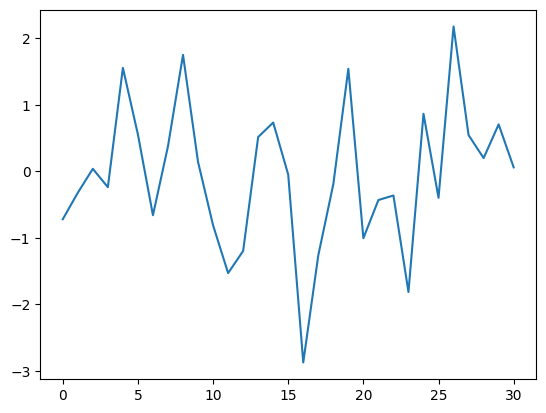

In [24]:
import matplotlib.pyplot as plt
i = 0
plt.plot(x[i])
x[i]

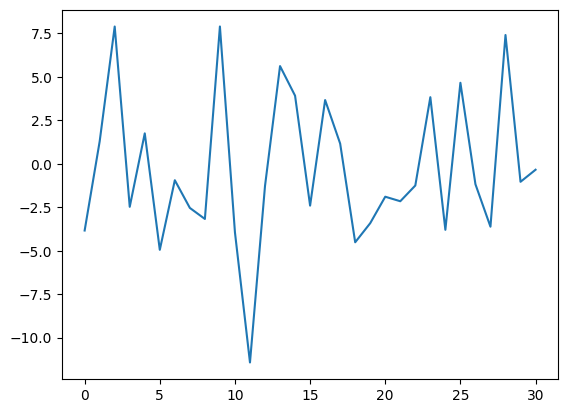

In [25]:
plt.plot(encdec.decode(x)[i])

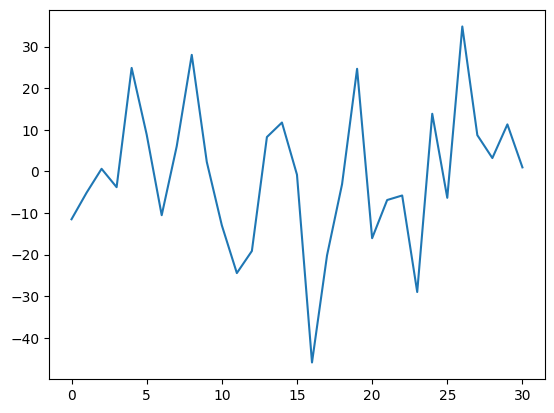

In [27]:
plt.plot(encdec.encode(encdec.decode(x))[i])

tensor([-0.1361, -0.0896,  0.2125, -0.3492, -0.6172,  0.2555,  0.3663,  0.1289,
         0.0900,  1.2624, -0.3733,  0.6312,  0.2627, -0.5129,  0.0634,  0.6400,
         0.0624, -1.2282,  0.2027, -0.3067,  0.3614, -0.3945, -0.8743,  0.9973,
        -0.7958, -0.0225,  0.5747, -0.6403, -1.2814, -0.0436,  0.1748])

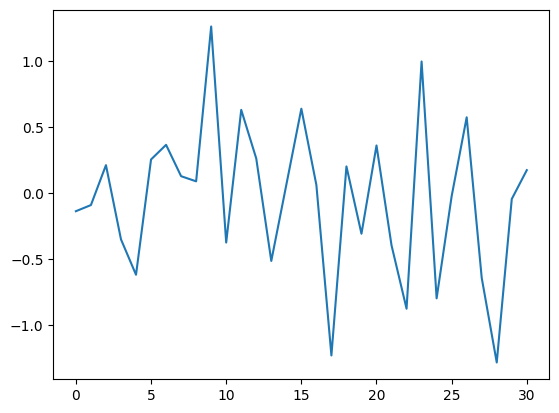

In [11]:
plt.plot(encdec.decode(encdec.encode(encdec.decode(x)[i])))
encdec.decode(encdec.encode(encdec.decode(x)[i]))